Time 0:
  Wealth 10.00: Best Action 1
Time 1:
  Wealth 10.00: Best Action 1
  Wealth 13.30: Best Action 1
  Wealth 15.00: Best Action 0
Time 2:
  Wealth 10.00: Best Action 1
  Wealth 13.30: Best Action 1
  Wealth 15.00: Best Action 0
  Wealth 17.69: Best Action 0
  Wealth 19.95: Best Action 0
  Wealth 22.50: Best Action 1
Time 3:
  Wealth 10.01: Best Action 0
  Wealth 13.30: Best Action 1
  Wealth 13.31: Best Action 1
  Wealth 15.01: Best Action 1
  Wealth 17.69: Best Action 1
  Wealth 19.95: Best Action 1
  Wealth 19.95: Best Action 1
  Wealth 22.50: Best Action 0
  Wealth 23.53: Best Action 0
  Wealth 26.53: Best Action 1
  Wealth 29.93: Best Action 1
  Wealth 33.75: Best Action 0
Time 4:
  Wealth 10.01: Best Action 1
  Wealth 13.31: Best Action 1
  Wealth 13.31: Best Action 0
  Wealth 15.01: Best Action 1
  Wealth 17.70: Best Action 1
  Wealth 17.70: Best Action 1
  Wealth 19.96: Best Action 1
  Wealth 19.96: Best Action 1
  Wealth 22.51: Best Action 1
  Wealth 23.53: Best Action 0


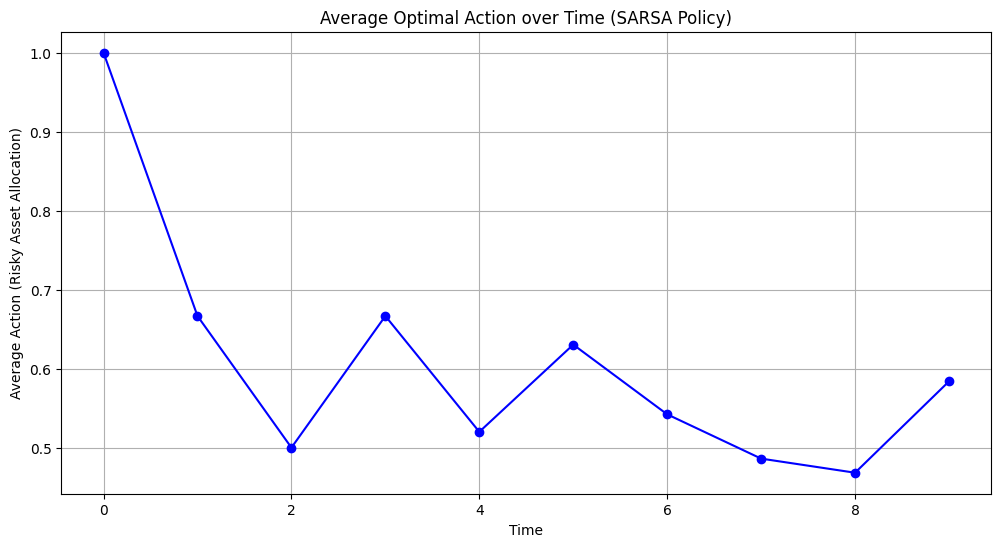

In [39]:
import numpy as np
from abc import ABC, abstractmethod

class Environment(ABC):
    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def step(self, action):
        pass

class AssetEnv(Environment):
    def __init__(self, initial_wealth=10, T=10, aversion_rate=0.01, riskless_return=0.0002,
                 risky_return=None, action_space=None):
        if risky_return is None:
            risky_return = {0.4: 0.5, 0.6: 0.33}  # 概率到收益率的映射
        if action_space is None:
            action_space = [0, 1]  # 可选择的投资比例

        self.aversion_rate = aversion_rate
        self.riskless_return = riskless_return
        self.risky_return = risky_return
        self.action_space = action_space
        self.initial_wealth = initial_wealth
        self.T = T

        # 初始化状态空间和转移概率
        self.state_space = {t: set() for t in range(T+1)}
        self.state_space[0].add(initial_wealth)
        self.transition_prob = self._generate_states_and_transitions()

    def _generate_states_and_transitions(self):
        transition_dict = {}
        for t in range(self.T):
            transition_dict[t] = {}
            for wealth in self.state_space[t]:
                transition_dict[t][wealth] = {}
                for action in self.action_space:
                    transitions = []
                    # 生成所有可能的转移
                    for prob, risky_r in self.risky_return.items():
                        next_wealth = np.round(
                            wealth * (action*(1+risky_r) + (1-action)*(1+self.riskless_return)),
                            3
                        )
                        self.state_space[t+1].add(next_wealth)
                        done = (t == self.T-1)
                        reward = self.cara_reward(next_wealth) if done else 0
                        transitions.append( (prob, next_wealth, reward, done) )
                    transition_dict[t][wealth][action] = transitions
        return transition_dict

    def reset(self):
        self.current_wealth = self.initial_wealth
        self.time_step = 0
        return self.current_wealth

    def step(self, action):
        transitions = self.transition_prob[self.time_step][self.current_wealth][action]
        probs = [t[0] for t in transitions]
        idx = np.random.choice(len(transitions), p=probs)
        _, next_wealth, reward, done = transitions[idx]
        
        self.current_wealth = next_wealth
        self.time_step += 1
        return next_wealth, reward, done, {}

    def cara_reward(self, wealth):
        return wealth

class SARSAAgent:
    def __init__(self, env, discount_factor=1, epsilon=0.8, alpha=0.7):
        self.env = env
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.alpha = alpha

        # 初始化Q表和策略
        self.Q = {}
        self.policy = {}
        for t in range(env.T):
            self.Q[t] = {}
            self.policy[t] = {}
            for wealth in env.state_space[t]:
                self.Q[t][wealth] = {a: 0.0 for a in env.action_space}
                self.policy[t][wealth] = self._init_policy(env.action_space)

    def _init_policy(self, actions):
        """ 初始化均匀随机策略 """
        return {a: 1/len(actions) for a in actions}

    def _update_policy(self, t, wealth):
        """ 使用ε-greedy策略更新 """
        best_action = max(self.Q[t][wealth], key=self.Q[t][wealth].get)
        for a in self.policy[t][wealth]:
            if a == best_action:
                self.policy[t][wealth][a] = 1 - self.epsilon + self.epsilon/len(self.env.action_space)
            else:
                self.policy[t][wealth][a] = self.epsilon/len(self.env.action_space)

    def choose_action(self, t, wealth):
        return np.random.choice(
            list(self.policy[t][wealth].keys()),
            p=list(self.policy[t][wealth].values())
        )

    def train(self, episodes=10000):
        for _ in range(episodes):
            wealth = self.env.reset()
            t = 0
            action = self.choose_action(t, wealth)
            done = False

            while not done:
                next_wealth, reward, done, _ = self.env.step(action)
                
                if done:
                    # 终止状态的更新
                    td_target = reward
                    self.Q[t][wealth][action] += self.alpha * (td_target - self.Q[t][wealth][action])
                    self._update_policy(t, wealth)
                    break
                
                # 选择下一个动作
                next_action = self.choose_action(t+1, next_wealth)
                
                # SARSA更新
                td_target = reward + self.gamma * self.Q[t+1][next_wealth][next_action]
                self.Q[t][wealth][action] += self.alpha * (td_target - self.Q[t][wealth][action])
                
                # 更新策略
                self._update_policy(t, wealth)
                
                # 转移到下一个状态
                wealth, action, t = next_wealth, next_action, t+1

        return self.Q, self.policy

if __name__ == '__main__':
    env = AssetEnv(initial_wealth=10, T=10)
    agent = SARSAAgent(env)
    Q, policy = agent.train(episodes=10000)
    # 输出最终策略示例
    hist = []
    for t in range(env.T):
        print(f"Time {t}:")
        for wealth in sorted(env.state_space[t]):
            best_action = max(policy[t][wealth], key=policy[t][wealth].get)
            hist.append(best_action)
            print(f"  Wealth {wealth:.2f}: Best Action {best_action}")
    import matplotlib.pyplot as plt
    import numpy as np

    # 计算每个时间步动作的平均值
    action_distribution = {}
    for t in range(env.T):
        actions_at_t = []
        for wealth in env.state_space[t]:
            best_action = max(policy[t][wealth], key=policy[t][wealth].get)
            actions = action_distribution.get(t, [])
            actions_at_t = actions + [best_action]
            action_distribution[t] = actions_at_t

    # 计算每个时间步动作的平均
    avg_actions = [np.mean(action_distribution[t]) for t in range(env.T)]

    # 绘制平均动作随时间变化的图表
    plt.figure(figsize=(12, 6))
    plt.plot(range(env.T), avg_actions, marker='o', linestyle='-', color='b')

    plt.xlabel('Time')
    plt.ylabel('Average Action (Risky Asset Allocation)')
    plt.title('Average Optimal Action over Time (SARSA Policy)')
    plt.grid(True)
    plt.show()


In [9]:
print(policy)

{0: {10: {0: 0.9500000000000001, 1: 0.05}}, 1: {40.0: {0: 0.9500000000000001, 1: 0.05}, 10.2: {0: 0.9500000000000001, 1: 0.05}, 60.0: {0: 0.9500000000000001, 1: 0.05}}, 2: {160.0: {0: 0.9500000000000001, 1: 0.05}, 40.8: {0: 0.9500000000000001, 1: 0.05}, 360.0: {0: 0.9500000000000001, 1: 0.05}, 10.404: {0: 0.9500000000000001, 1: 0.05}, 240.0: {0: 0.9500000000000001, 1: 0.05}, 61.2: {0: 0.9500000000000001, 1: 0.05}}, 3: {960.0: {0: 0.9500000000000001, 1: 0.05}, 640.0: {0: 0.9500000000000001, 1: 0.05}, 1440.0: {0: 0.9500000000000001, 1: 0.05}, 163.2: {0: 0.9500000000000001, 1: 0.05}, 41.616: {0: 0.9500000000000001, 1: 0.05}, 10.612: {0: 0.05, 1: 0.9500000000000001}, 367.2: {0: 0.9500000000000001, 1: 0.05}, 2160.0: {0: 0.9500000000000001, 1: 0.05}, 244.8: {0: 0.9500000000000001, 1: 0.05}, 62.424: {0: 0.9500000000000001, 1: 0.05}}, 4: {5760.0: {0: 0.9500000000000001, 1: 0.05}, 3840.0: {0: 0.5, 1: 0.5}, 2560.0: {0: 0.9500000000000001, 1: 0.05}, 8640.0: {0: 0.5, 1: 0.5}, 12960.0: {0: 0.5, 1: 

In [10]:
print(Q)

{0: {10: {0: 192262.02493944138, 1: 134138.02303605064}}, 1: {40.0: {0: 164857.12247920304, 1: 33242.89794420052}, 10.2: {0: 199191.4608254366, 1: 185934.87699244954}, 60.0: {0: 186623.8830523928, 1: 34630.55403707629}}, 2: {160.0: {0: 18720.380308215386, 1: 9726.131220592879}, 40.8: {0: 213624.01648142078, 1: 32716.134481505847}, 360.0: {0: 41183.103134607794, 1: 1275.5764355797214}, 10.404: {0: 199265.7001066456, 1: 190474.72873615136}, 240.0: {0: 49977.60100875397, 1: 14846.827794050474}, 61.2: {0: 241245.13711239363, 1: 48308.42592036529}}, 3: {960.0: {0: 39602.51811983528, 1: 0.0}, 640.0: {0: 7309.741677046059, 1: 0.0}, 1440.0: {0: 11656.699845553867, 1: 0.0}, 163.2: {0: 27396.7519900967, 1: 26236.084050973717}, 41.616: {0: 181975.58282555264, 1: 43832.84168790288}, 10.612: {0: 594.819270306094, 1: 194509.2267328755}, 367.2: {0: 52592.711120792825, 1: 32252.53928171603}, 2160.0: {0: 122.14871332184885, 1: 0.0}, 244.8: {0: 60478.477759639376, 1: 46067.87084168532}, 62.424: {0: 3620